# Magnetic Data Transformation

In this notebook you will undertake the data processing steps that are necessary in order to produce a magnetic anomaly map

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pathlib import Path
from scipy import interpolate
import pyproj
import warnings
import os

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
warnings.filterwarnings("ignore")


## Defining Functions (Fatiando Legacy)
We will use a few functions in order to perform typical transformation. These are saved in function.py file that you should be in the same folder as this notebook.  
The functions are imported in the following cell.


In [2]:
import functions
from functions import reduce_to_pole
from functions import upcontinue

The following cell will define plotting functions, that will plot our data without having to define all the plotting parameters each time.

In [3]:
#Plot Functions
def plot_interpol(mgX,mgY,data,title="interpolation method"):
    fig,ax  = plt.subplots()
    im = ax.contourf(mgX, mgY, data.reshape(mgX.shape),
                    vmin=vmin, vmax=vmax, cmap="RdBu_r")
    ax.scatter(data_combined['x'], data_combined['y'])
    ax.set(xlabel='Easting', ylabel='Northing', title='Anomalies from {} data_raw'.format(title))
    ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
    ax.set_xticklabels(['{:}'.format(int(x)) for x in ax.get_xticks().tolist()]) # Fixes y-axis tick labels
    plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
    plt.tight_layout()

def plot_map(mgX,mgY,data,map_size=0.0005,title="data method"):
    #Plotting interpolation on OpenStreetMap
    plt.figure(figsize=(8,8))
    request = cimgt.OSM();
    # Bounds: (lon_min, lon_max, lat_min, lat_max):
    extent = [data_combined["lon"].min()-map_size,data_combined["lon"].max()+map_size,data_combined["lat"].min()-map_size,data_combined["lat"].max()+map_size]
    ax = plt.axes(projection=request.crs);
    ax.set_extent(extent);
    ax.add_image(request,18 )    # 18 = zoom level
    ax.scatter(data_combined["lon"], data_combined["lat"] ,transform=ccrs.PlateCarree())
    im = ax.contourf(mgX, mgY, data.reshape(mgX.shape),transform=ccrs.PlateCarree(),
                    vmin=vmin, vmax=vmax, cmap="RdBu_r",alpha=0.4);
    # plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
    ax.set(title="Interpolation {} map".format(title));
    ax.gridlines(draw_labels=True);

def plot_transform(mgX,mgY,data_raw,data_transformed,title="Transformed data"):
    fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
    ax = axes[0]
    amp = np.abs([data_raw.min(),data_raw.max()]).max()
    im =ax.contourf(mgX, mgY, data_raw.reshape(mgX.shape),
                vmin=vmin, vmax=vmax, cmap="RdBu_r")
    ax.scatter(data_combined['x'], data_combined['y'])
    ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
    ax.set_xticklabels(['{:}'.format(int(x)) for x in ax.get_xticks().tolist()]) # Fixes y-axis tick labels
    fig.colorbar(im, ax=ax, pad=0.1, aspect=30,
                orientation='horizontal').set_label('nT')
    ax.set_title(u'Raw data'.format(inc))
    ax.set(xlabel="easting",ylabel="northing")
    ax = axes[1]
    amp = np.abs([data_transformed.min(),data_transformed.max()]).max()
    im =ax.contourf(mgX, mgY, data_transformed.reshape(mgX.shape),
                vmin=-amp, vmax=amp, cmap="RdBu_r")
    ax.scatter(data_combined['x'], data_combined['y'])
    ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
    ax.set_xticklabels(['{:}'.format(int(x)) for x in ax.get_xticks().tolist()]) # Fixes y-axis tick labels
    fig.colorbar(im, ax=ax, pad=0.1, aspect=30,
                orientation='horizontal').set_label('nT')
    ax.set_title(u'{}'.format(title))
    ax.set(xlabel="easting",ylabel="northing")

## Importing & Combining 
After every student processed their recorded data, it is time to combine all data for further processing

In [4]:
dr =Path(r'C:\Users\julik\sciebo\Master\Geophyphox\Excursion 2022\Student Data\Processed')
preamble = 'results_magnetic_' # The filename beginning common to all magnetic data files
preambleBASE = 'results_magneticBASE_' # Filename beginning for all base station data

alldata = [] # Empty list for storing all dataframes
basedata = [] # Empty list for storing all base station dataframes

for file in os.scandir(dr):
    if file.is_file and file.name.endswith('.csv') and file.name.startswith(preamble): # Check if this is a data file
        alldata.append(pd.read_csv(file))
    elif file.is_file and file.name.endswith('.csv') and file.name.startswith(preambleBASE): # Check if this is a data file
        basedata.append(pd.read_csv(file))
        
data_combined = pd.concat(alldata, ignore_index=True)
base_combined = pd.concat(basedata, ignore_index=True)
data_combined["name"].unique()
data_combined.to_csv(r"C:/Users/julik/sciebo/Master/Data/Excursion 2021/Raw/Dürwiss/Dürwiss_combined.csv")
data_combined.head()

,Unnamed: 0,station,lat,lon,altitude,mag_x_,mag_y,mag_z,field,mag_abs_std,time,unix_time,mag_count,student_id,x,y,times,anomaly,name
0,0,0.0,50.789909,6.052094,199.556366,17.142782,-1.949070,-45.260158,48439.74882,0.247992,69.067,1.656332e+09,70.0,111111.0,292232.205677,5.630605e+06,51275.0,300.484097,Random
1,1,1.0,50.789842,6.052318,197.745369,16.140990,-1.605669,-45.880851,48665.60762,0.320597,141.333,1.656332e+09,70.0,111111.0,292247.725679,5.630597e+06,51347.0,502.413464,Random
2,2,2.0,50.789855,6.052401,197.895947,18.262659,3.349937,-44.909200,48599.05842,0.302315,175.865,1.656332e+09,70.0,111111.0,292253.591060,5.630599e+06,51381.0,424.564255,Random
3,3,3.0,50.789902,6.052459,197.055683,16.223378,1.876468,-45.716157,48550.03956,0.300786,219.949,1.656332e+09,70.0,111111.0,292257.877043,5.630604e+06,51425.0,360.921853,Random
4,4,4.0,50.789857,6.052536,195.836199,17.241568,1.766314,-45.299987,48506.95899,0.325299,276.127,1.656332e+09,70.0,111111.0,292263.106204,5.630598e+06,51482.0,298.897148,Random


## Plotting all data

We can now visualize all collected data. Starting with a scatterplot:

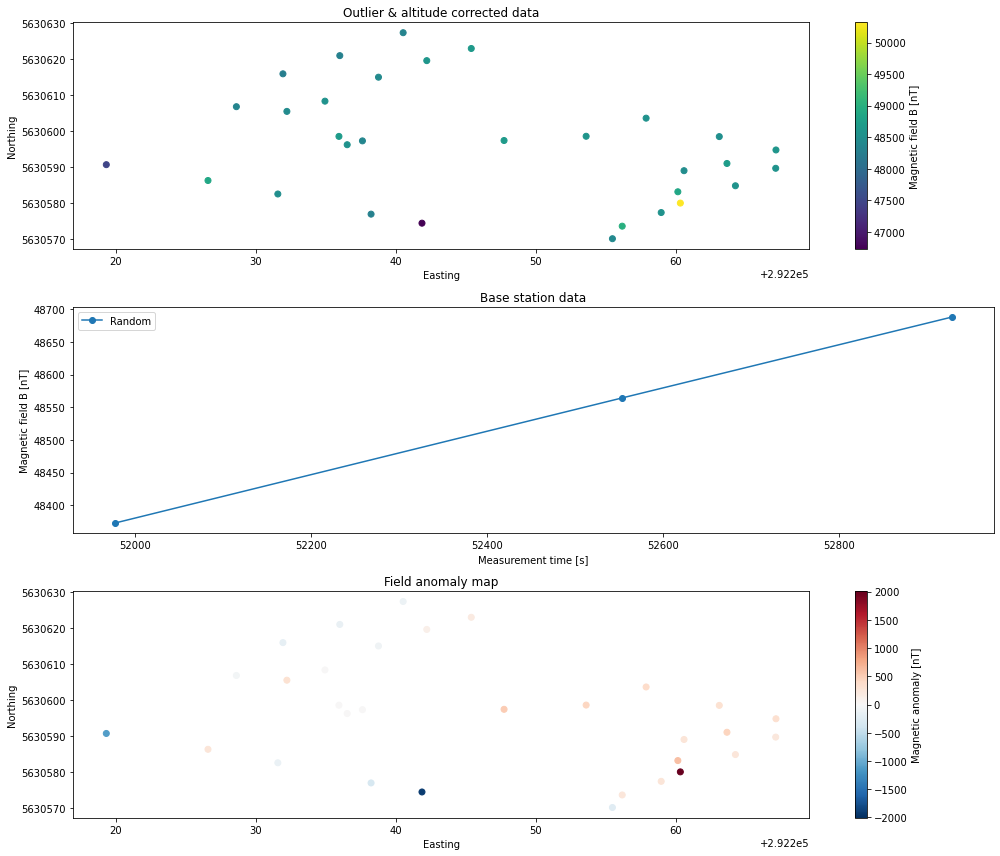

In [5]:
# Basic Anomaly map
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(14, 12))

vmin = -np.max(np.abs(data_combined['anomaly']))
vmax = np.max(np.abs(data_combined['anomaly']))

# Using the temporally corrected anomalies
im0 = ax0.scatter(data_combined['x'], data_combined['y'], c=data_combined['field'])
namegroups = base_combined.groupby('name')
for name, group in namegroups:
    ax1.plot(group['times'], group['field'], '-o', label=name)
ax1.legend()
im2 = ax2.scatter(data_combined['x'], data_combined['y'], c=data_combined['anomaly'],
                  vmin=vmin, vmax=vmax, cmap="RdBu_r")

ax0.set(xlabel='Easting', ylabel='Northing', title='Outlier & altitude corrected data')
ax1.set(xlabel='Measurement time [s]', ylabel='Magnetic field B [nT]', title='Base station data')
ax2.set(xlabel='Easting', ylabel='Northing', title='Field anomaly map')
plt.colorbar(im0, ax=ax0, label='Magnetic field B [nT]');
#plt.colorbar(im1, ax=ax1, label='Magnetic field B [nT]');
plt.colorbar(im2, ax=ax2, label='Magnetic anomaly [nT]');

ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
ax2.set_yticklabels(['{:}'.format(int(x)) for x in ax2.get_yticks().tolist()]) # Fixes y-axis tick labels

plt.tight_layout()

## Spatial anomaly plot & map visualization
We can produce a more sophisticated, continous map of our data using interpolation. Several common interpolation algorithms exist, such as polynomial interp., spline interp., and kriging.  
A very straight-forward interpolation method is Nearest Neighbors, which simply assigns the unsampled point of interest the value of the sampled point that lies closest.


Additionally using the python package [cartopy](https://scitools.org.uk/cartopy/docs/latest/) we can visualize our measurement locations maps from OpenStreetMap.


In [6]:
# Defining a grid of points for which we want to interpolate
# Defining resolution (number of gridpoints) in x- and y- direction
xRes = 100
yRes = xRes

xAxis = np.linspace(data_combined['x'].min(), data_combined['x'].max(), xRes)
yAxis = np.linspace(data_combined['y'].min(), data_combined['y'].max(), yRes)

vmin = -np.max(np.abs(data_combined['anomaly']))
vmax = np.max(np.abs(data_combined['anomaly']))

# Numpy offers the meshgrid function which simplifies some input operations
mgX, mgY = np.meshgrid(xAxis, yAxis)

#Open Street Map Visualization
projection = pyproj.Proj(proj='utm',zone=32, lat_ts=data_combined['lat'].mean()) #'merc',proj='utm',zone=32,ellps='WGS84'
# Project the interpolated coordinates back to longitude-latitude:
mgEasting, mgNorthing = projection(mgX, mgY,inverse=True)

In [7]:
# Performing interpolation for all gridpoints
nearest_neighbors = interpolate.griddata(list(zip(data_combined['x'], data_combined['y'])), data_combined['anomaly'],
                                         list(zip(mgX.flat, mgY.flat)), method='nearest')
# Spline interpolation

linear_spline = interpolate.griddata(list(zip(data_combined['x'], data_combined['y'])), data_combined['anomaly'],
                                     list(zip(mgX.flat, mgY.flat)), method='linear',fill_value=0)


#### Nearest Neighbors

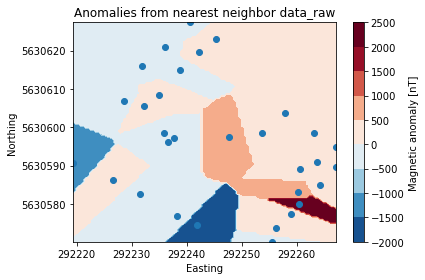

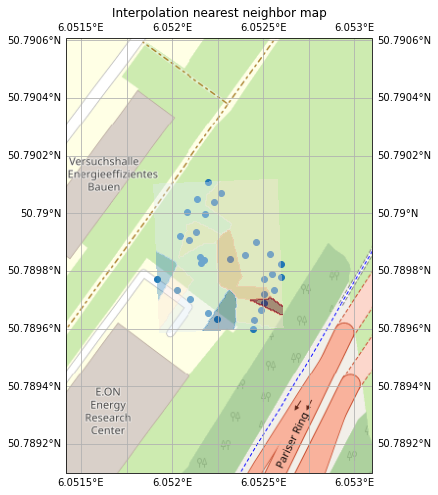

In [8]:
plot_interpol(mgX,mgY,nearest_neighbors,title="nearest neighbor")
plot_map(mgEasting,mgNorthing,nearest_neighbors, title="nearest neighbor")

#### Linear Spline

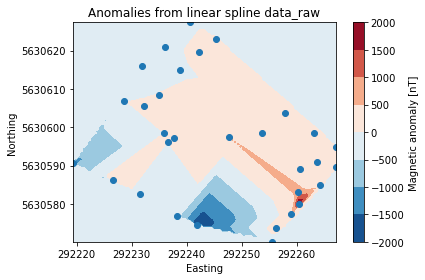

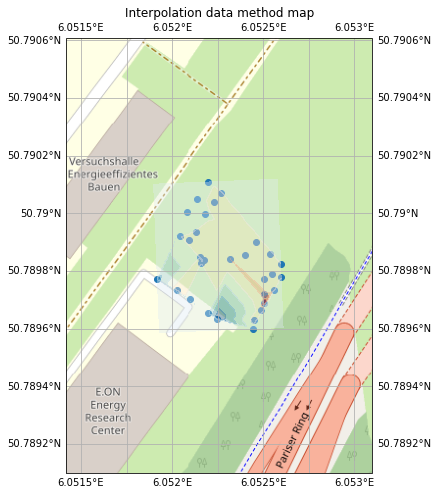

In [9]:
plot_interpol(mgX,mgY,linear_spline,title="linear spline")
plot_map(mgEasting,mgNorthing,linear_spline)

## Reduction to pole (RTP)
RTP is a method which removes the dependence of magnetic data on magnetic inclination. Magnetic data is transformed to a field which would have been measured   
at the poles, where the field is vertical. That way anomaly asymemmetry is removed. ([SEG-Wiki](https://wiki.seg.org/wiki/Dictionary:Reduction_to_the_pole_(RTP)))

Input:
- x-coordinates
- y-coordinates
- data = magnetic field anomaly
- shape of data grid
- dec,inc = sdec,sinc = Declination, Inclination of earths magnetic field at location



### Synthetic Example
Several synthetic magnetized prism located in a certain depth is used to showcase how reduction to pole can improve anomaly visibility.  
This data was created and plotted using Fatiando Legacy Code!

[Text(0.5, 0, 'km'), Text(0, 0.5, 'km')]

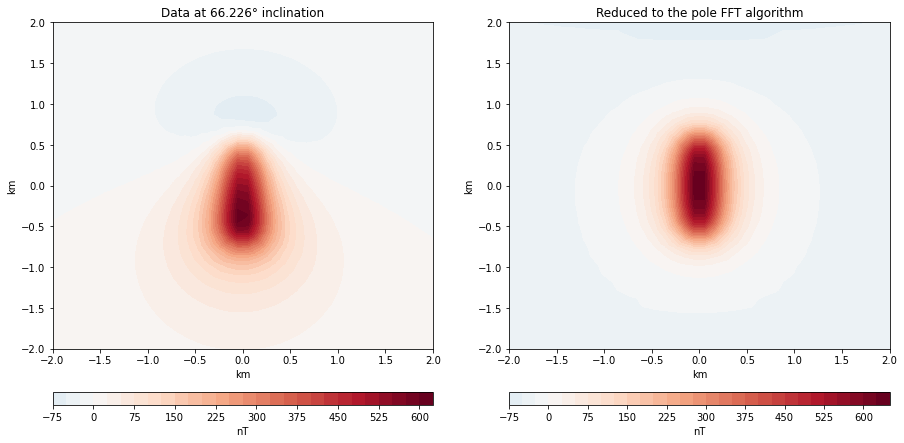

In [10]:
df = pd.read_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Excursion 2022\Synthetic Data\synthetic_RTP.csv")
inc, dec = 66.226, 2.16
df["rtp_fft"] = reduce_to_pole(x=df["x"].values,y=df["y"].values,data=df["data"].values,shape=(40,40),inc=inc,dec= dec,sinc=inc, sdec=dec)
amp = np.abs([df["data"].min(),df["data"].max()]).max()
fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]

im =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["data"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)
fig.colorbar(im, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Data at {}° inclination'.format(inc))
ax.set(xlabel="km",ylabel="km")


ax = axes[1]
amp = np.abs([df["rtp_fft"].min(),df["rtp_fft"].max()]).max()

im =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["rtp_fft"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)
fig.colorbar(im, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Reduced to the pole FFT algorithm')
ax.set(xlabel="km",ylabel="km")

### Excursion Data
Now we apply this RTP transformation to the actual data we measured!

Text(0.5, 0.98, 'Nearest Neighbors')

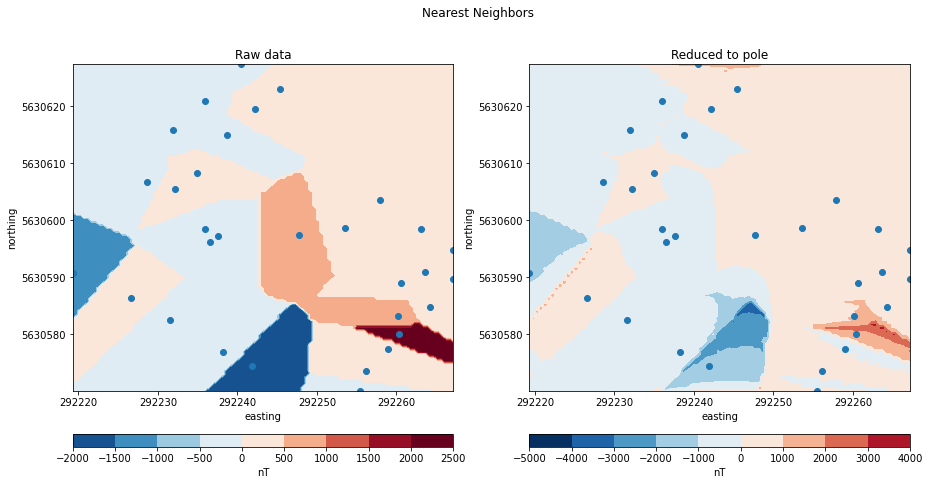

In [11]:
inc, dec = 66.226, 2.16
rtp_nearest = reduce_to_pole(mgX.flatten() , mgY.flatten(), nearest_neighbors, shape=(xRes,yRes),
                inc=inc,dec= dec,sinc=inc, sdec=dec)

plot_transform(mgX,mgY,nearest_neighbors,rtp_nearest,title="Reduced to pole")
plt.suptitle("Nearest Neighbors")

Text(0.5, 0.98, 'Linear Spline')

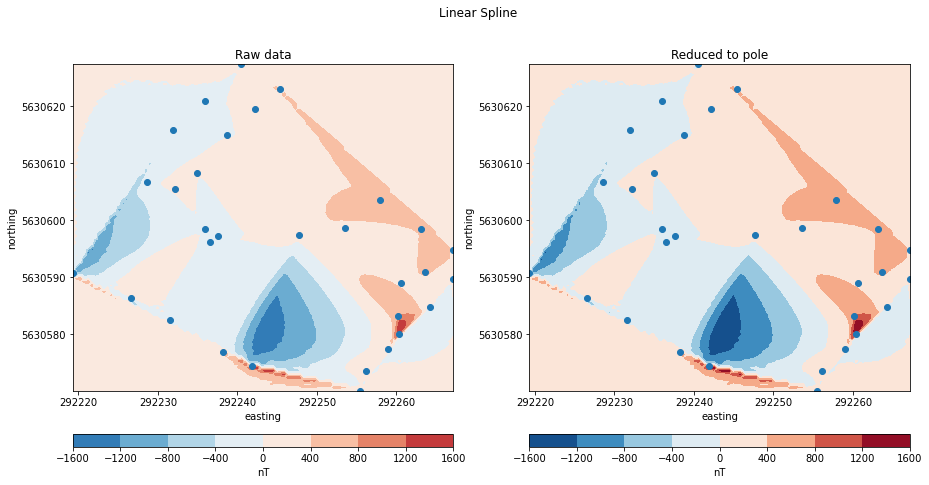

In [12]:
inc, dec = 66.226, 2.16
rtp_spline = reduce_to_pole(mgX.flatten() , mgY.flatten(), linear_spline, shape=(xRes,yRes),
                inc=inc,dec= dec,sinc=inc, sdec=dec)

plot_transform(mgX,mgY,rtp_spline,rtp_spline,title="Reduced to pole")
plt.suptitle("Linear Spline")

## Upward Continuation  
Upward continuation is a method which can be used for magnetic as well as gravitational data. The data is extrapolated to a higher elevation than it was measured. This procedure can smooth out near surface effects or help improve aeromagnetic surveys.  

Input:
- x-coordinates
- y-coordinates
- data = magnetic field strength
- shape of data grid
- height
 


### Synthetic Example
Multiple shallow buried and one deep prism anomaly.  
This data was created and plotted using Fatiando Legacy Code!

[Text(0.5, 0, 'km'), Text(0, 0.5, 'km')]

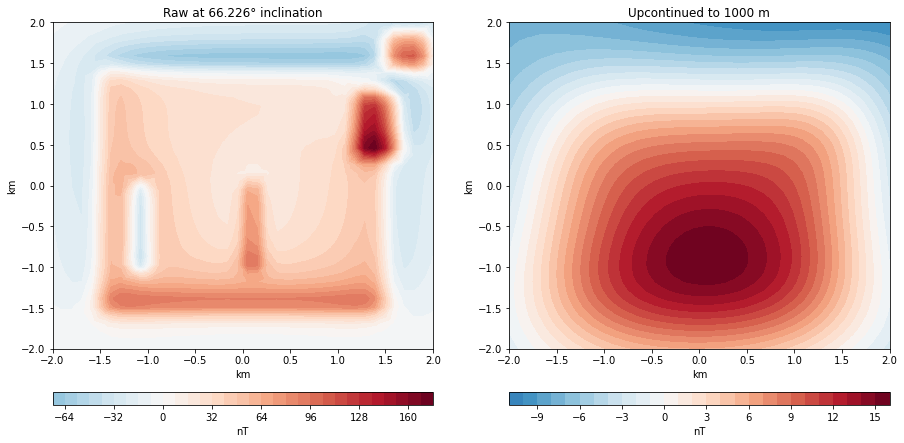

In [13]:
df = pd.read_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Excursion 2022\Synthetic Data\synthetic_upward.csv")
inc, dec = 66.226, 2.16
height = 1000

df["upcontinue"] = upcontinue(x=df.x.values,y=df.y.values,data=df.data.values,shape=(40,40),height=height)

amp = np.abs([df["data"].min(),df["data"].max()]).max()
fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]

im =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["data"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)

fig.colorbar(im, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Raw at {}° inclination'.format(inc))
ax.set(xlabel="km",ylabel="km")

ax = axes[1]
amp = np.abs([df["upcontinue"].min(),df["upcontinue"].max()]).max()

im =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["upcontinue"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)
fig.colorbar(im, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Upcontinued to '+'{0} m'.format(height))
ax.set(xlabel="km",ylabel="km")


### Excursion Data
Now we apply upward continuation on the actual data we measured!

Now using real data, from our excursion

Text(0.5, 0.98, 'Nearest Neighbor')

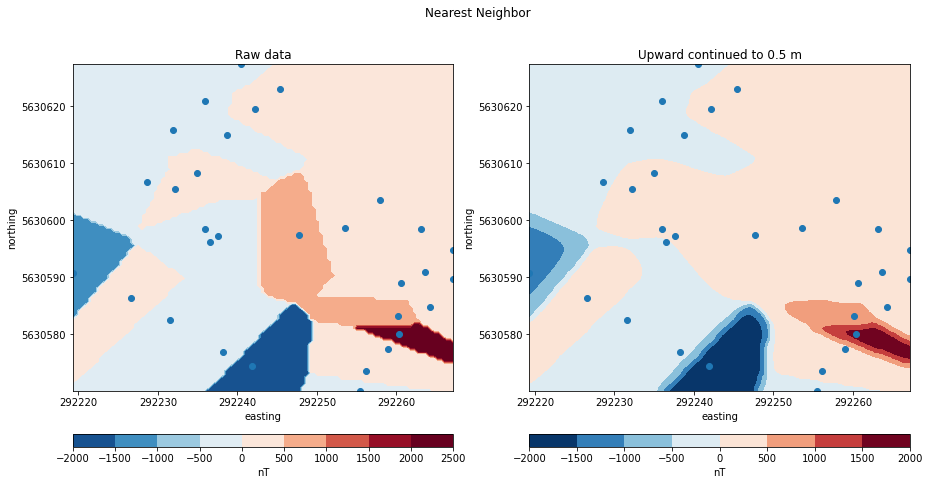

In [14]:
h  = 0.5
upward_nearest = upcontinue(mgX.flatten() , mgY.flatten(), nearest_neighbors, shape=(xRes,yRes),
                height=h)

plot_transform(mgX,mgY,nearest_neighbors,upward_nearest,title="Upward continued to {} m".format(h))
plt.suptitle("Nearest Neighbor")


Text(0.5, 0.98, 'Linear Spline')

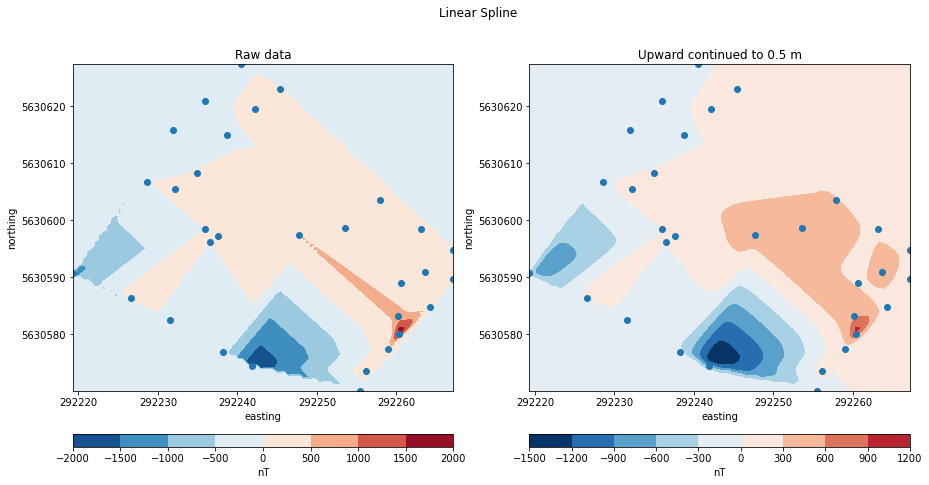

In [15]:
h  = 0.5
upward_spline = upcontinue(mgX.flatten() , mgY.flatten(), linear_spline, shape=(xRes,yRes),
                height=h)

plot_transform(mgX,mgY,linear_spline,upward_spline,title="Upward continued to {} m".format(h))
plt.suptitle("Linear Spline")

## Extracting profile line
Clicking on the plot will save the coordinates.  
The cell below the plot will show the clicked positions coordinate

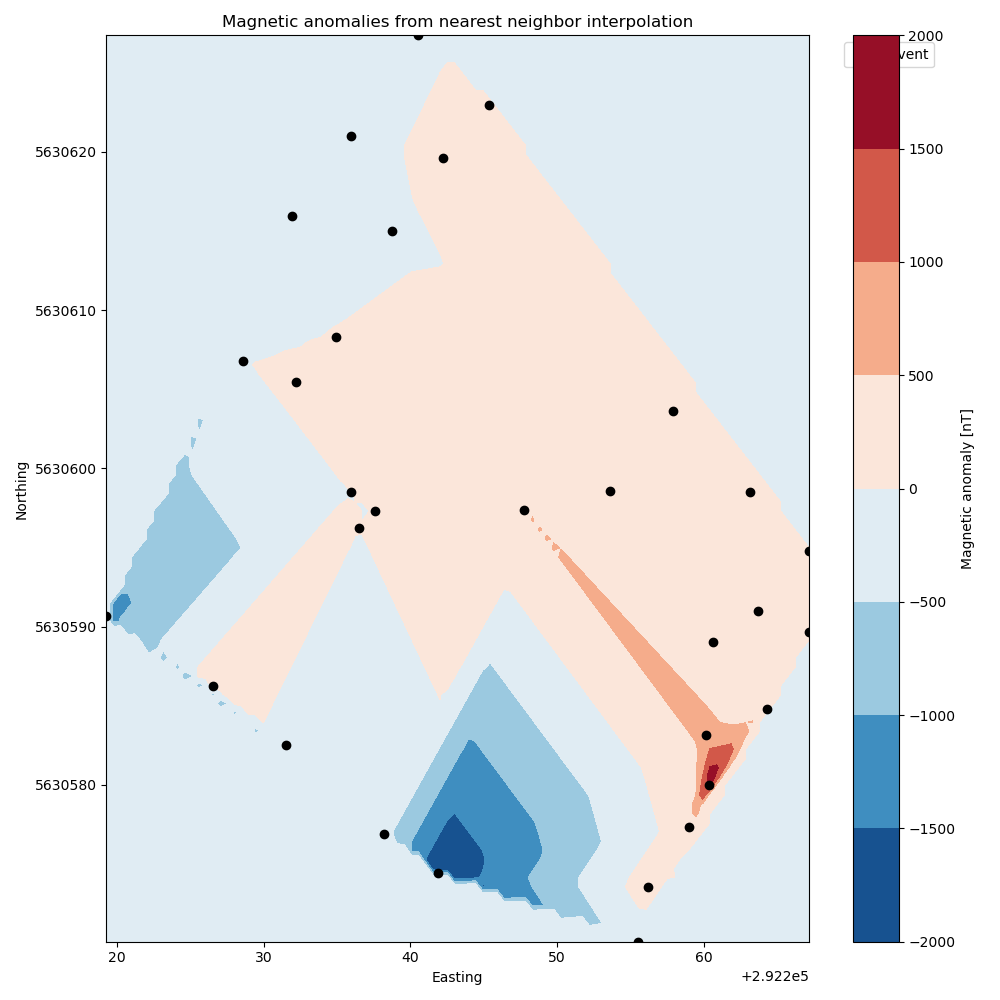

In [16]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker

fig, ax = plt.subplots(figsize=(10,10))
im  =ax.contourf(mgX, mgY, linear_spline.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")
ax.set(xlabel='Easting', ylabel='Northing', title='Magnetic anomalies from nearest neighbor interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()
klicker = clicker(ax, ["event"], markers=["x"],colors="black")
plt.show()


In [17]:
#Print profile start and end
print(klicker.get_positions())

{'event': array([[ 292233.00291072, 5630611.8975405 ],
       [ 292255.06265433, 5630614.67768273]])}


In [35]:
%matplotlib inline
from matplotlib.patches import Polygon

# Enter Starting point coordinates here
profileStartX,profileStartY =   292228.19425724, 5630603.62526547


# Enter coordinates of profile endpoint here
profileEndX,profileEndY  = 292262.16898583, 5630579.29902099
tol = 0.5

# Create a slim polygon that represents the profile line
selection = Polygon([[profileStartX-tol/2, profileStartY-tol/2], [profileEndX-tol/2, profileEndY-tol/2],
                    [profileEndX+tol/2, profileEndY+tol/2], [profileStartX+tol/2, profileStartY+tol/2]])

# Selecting datapoints that lie along the profile
selectMask = selection.contains_points(list(zip(data_combined['x'], data_combined['y'])))
profileX = data_combined['x'][selectMask]
profileY = data_combined['y'][selectMask]
profileAnomaly = np.array(data_combined['anomaly'][selectMask])

# Selecting points from the interpolation grid 
selectMaskInterp = selection.contains_points(list(zip(mgX.flat, mgY.flat)))
profileXInterp = mgX.flat[selectMaskInterp]
profileYInterp = mgY.flat[selectMaskInterp]
profileAnomalyInterp = np.array(linear_spline.flat[selectMaskInterp]) # Change linear_spline to desired interpolation

# # Computing distances along the profile
distances = []
for _x, _y in zip(profileX, profileY):
    distances.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
distances = np.array(distances)
distances_sorted = distances[distances.argsort()]
anomalies_sorted = profileAnomaly[distances.argsort()]

# # Computing distances for interpolated data
distancesInterp = []
for _x, _y in zip(profileXInterp, profileYInterp):
    distancesInterp.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
distancesInterp = np.array(distancesInterp)
distances_sortedInterp = distancesInterp[distancesInterp.argsort()]
anomalies_sortedInterp = profileAnomalyInterp[distancesInterp.argsort()]

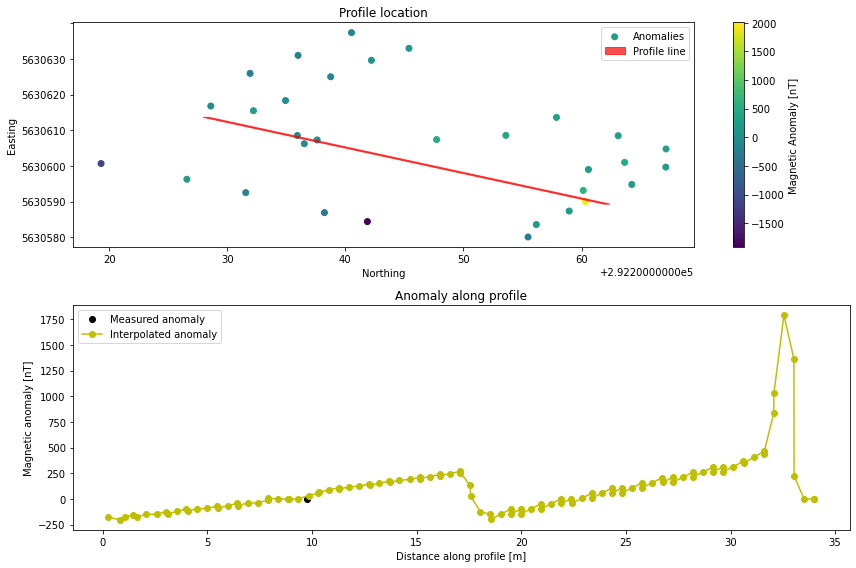

In [92]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8))

selection_plot = Polygon([[profileStartX-tol/2, profileStartY], [profileEndX-tol/2, profileEndY],
                         [profileEndX+tol/2, profileEndY], [profileStartX+tol/2, profileStartY]],
                         label='Profile line', color='r', alpha=.7)

ax0.add_patch(selection_plot)
im0 = ax0.scatter(data_combined['x'], data_combined['y'], c=data_combined['anomaly'], label='Anomalies')
im1 = ax1.plot(distances, profileAnomaly, 'ok', label='Measured anomaly')
im2 = ax1.plot(distances_sortedInterp, anomalies_sortedInterp, '-oy', label='Interpolated anomaly')

ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
ax0.legend(handles=[im0, selection_plot])
ax1.legend()

ax0.set(xlabel='Northing', ylabel='Easting', title='Profile location')
ax1.set(xlabel='Distance along profile [m]', ylabel='Magnetic anomaly [nT]', title='Anomaly along profile')
plt.colorbar(im0, ax=ax0, label='Magnetic Anomaly [nT]');

plt.tight_layout()

Saving profile data

In [58]:
# Give your profile a meaningful name and choose a folder (default is this notebooks' folder)
# The following code will save the measured profile data and teh interpolated profiledata into 2 different .csv files
profilefolder = Path(r'C:\Users\julik\sciebo\Master\Geophyphox\Student Data\Profiles')
profilename = 'profile'

profiledata_measured = pd.DataFrame({'Measured distance':distances_sorted,
                                     'Measured anomaly':anomalies_sorted})
profiledata_interpolated = pd.DataFrame({'Measured distance':distances_sortedInterp,
                                     'Measured anomaly':anomalies_sortedInterp})

profiledata_measured.to_csv(profilefolder / (profilename+'_measured.csv'))
profiledata_interpolated.to_csv(profilefolder / (profilename+'_interpolated.csv'))